# Regularized Linear Regression and Bias v.s. Variance

前半部分练习，使用正则化的线性回归，使用水位变化来预测一个水坝的出水量。

后半部分，通过debug算法来测试偏差与方差的影响

## Regularized Linear Regression

### Visualizing the dataset

This dataset is divided into threes parts:

- A training set that your model will learn on : X, y
- **A cross validation** set for determining the regularization parameter:  Xval, yval
- A test set for evaluating performance. These are "unseen" examples which your model did not see during training: Xtest, ytest

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat

In [2]:
def load_data(filename):
    data = loadmat(filename)
    return map(np.ravel, [data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')

In [4]:
X.shape, Xval.shape, y.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (21,), (12,), (21,), (21,), (21,))

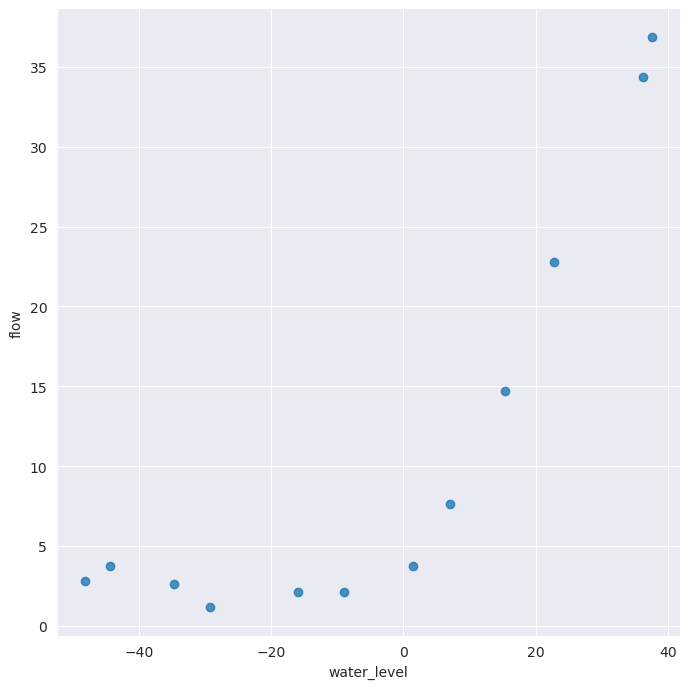

In [5]:
df = pd.DataFrame({'water_level':X, 'flow':y})

import seaborn as sns

sns.lmplot(x="water_level", y="flow", data=df, fit_reg=False, height=7)
plt.show()

<Axes: xlabel='water_level', ylabel='flow'>

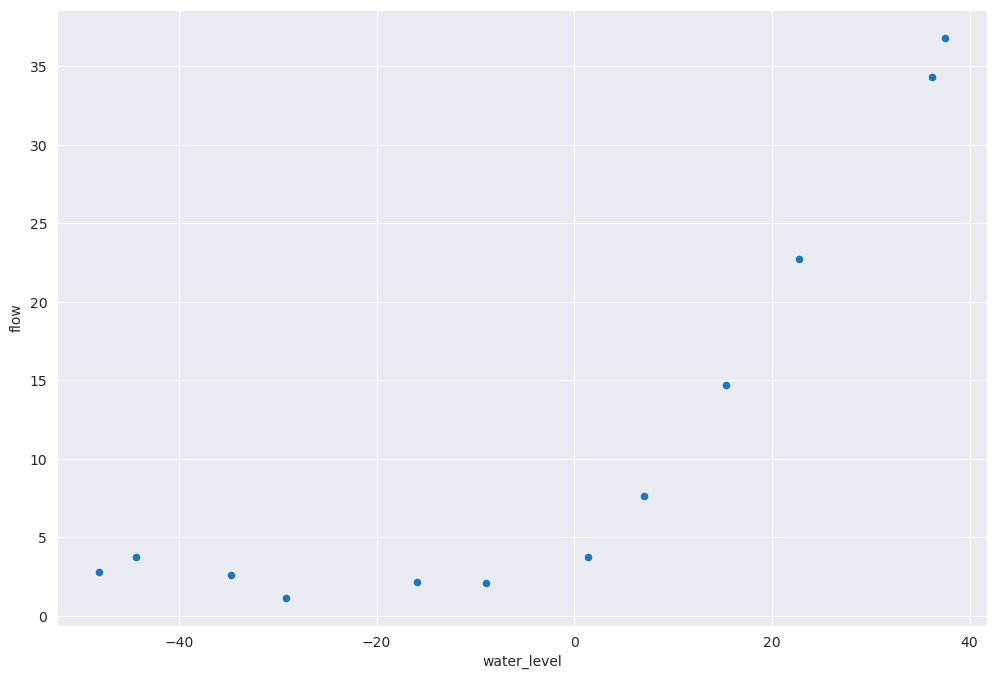

In [6]:
df.plot(kind='scatter', x='water_level', y='flow', figsize=((12,8)))

In [7]:
X, Xval, Xtest = [np.insert(x.reshape(-1, 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

## cost

$$
J(\theta) = \frac{1}{2m}\left( \sum_{i = 1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})^2 \right) + \frac{\lambda}{2m}\left( \sum_{j = 1}^{n} \theta_{j}^{2} \right)
$$

In [8]:
def cost(theta, X, y):
    m = X.shape[0]

    error = X @ theta - y

    return error.T @ error / (2 * m)

In [9]:
t = np.ones(X.shape[1])
cost(theta=t, X=X, y=y)

np.float64(303.9515255535976)

In [10]:
def cost_reg(theta, X, y, lambda_=1):
    term = theta.copy()
    term[0] = 0 # 偏置项不参与计算
    reg = term.T @ term
    reg *= lambda_ / (2 * len(X))

    return cost(theta, X, y) + reg

In [11]:
cost_reg(theta=t, X=X, y=y)

np.float64(303.9931922202643)

## gradient

\begin{align*}
\frac{\partial J(\theta)}{\partial \theta_0} &= \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_0^{(i)} \\
\frac{\partial J(\theta)}{\partial \theta_j} &= \left( \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j \quad \text{对于 } j \geq 1
\end{align*}

In [12]:
def gradient(theta, X, y):
    return X.T @ (X @ theta - y) / len(X)

In [13]:
gradient(theta=t, X=X, y=y)

array([-15.30301567, 598.16741084])

In [14]:
def gradient_reg(theta, X, y, lambda_=1):
    term = theta.copy()
    term[0] = 0
    term *= lambda_ / len(X)

    return gradient(theta, X, y) + term

In [15]:
gradient_reg(theta=t, X=X, y=y)

array([-15.30301567, 598.25074417])

## Fitting linear regression

In [16]:
import scipy.optimize as opt
def train_linear_reg( X, y, lambda_=1, theta = None):
    if theta is None:
        theta = np.ones(X.shape[1])
    return opt.minimize(fun=cost_reg,
                       x0=theta,
                       args=(X, y, lambda_),
                       method='TNC',
                       jac=gradient_reg,
                       options={'disp': True}).x

在这一部分我们设置lambda为0

In [17]:
final_theta = train_linear_reg(theta=t, X=X, y=y, lambda_=0)

  NIT   NF   F                       GTG
    0    1  3.039515255535976E+02   3.58038434E+05
tnc: fscale = 0.000835613
    1    3  9.299577620594808E+01   1.36988336E+02
tnc: fscale = 0.0427197
    2    5  4.008652214831358E+01   2.25223345E+04
    3    7  2.237390649510891E+01   1.91663765E-13
tnc: |pg| = 1.02481e-05 -> local minimum
    3    7  2.237390649510891E+01   1.91663765E-13
tnc: Local minima reach (|pg| ~= 0)


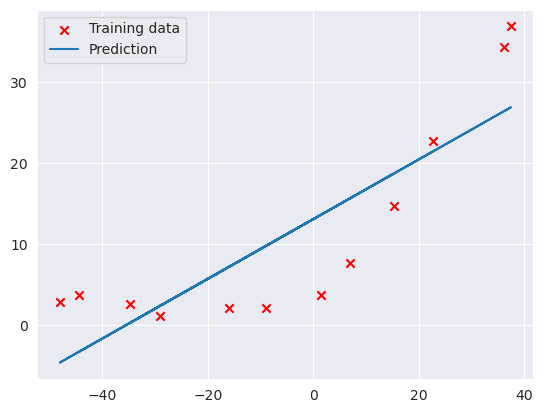

In [18]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data", marker='x', color='red')
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

## Bias-variance

### Learning curves

- 使用训练集的子集来拟合
    - 对于训练集大小i，应该使用前i个示例（即X[1:i,:],y[1:i])
- 训练误差不包括常规化项
    - 在计算train error and cross validation error时设置$\lambda =0$

In [19]:
train_cost, cross_validation_cost = [], []

In [20]:
for i in range(1, len(X) + 1):
    res = train_linear_reg(X=X[:i, :], y=y[:i], lambda_=0)

    tc = cost_reg(theta=res, X=X[:i, :], y=y[:i], lambda_=0)
    train_cost.append(tc)
    cv = cost_reg(theta=res, X=Xval, y=yval, lambda_=0)
    cross_validation_cost.append(cv)

  NIT   NF   F                       GTG
    0    1  1.457106922645887E+02   7.43067003E+04
tnc: fscale = 0.00183424
    1    3  8.631534185484672E-18   4.40174166E-15
tnc: |pg| = 3.61706e-05 -> local minimum
    1    3  8.631534185484672E-18   4.40174166E-15
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.878623740891748E+02   3.18073041E+05
tnc: fscale = 0.000886557
    1    3  2.004821342908418E-01   3.16698305E-02
tnc: fscale = 2.80962
    2    5  1.406351957431711E-04   1.55393840E-01
    3    7  1.198297373799073E-17   1.11887202E-17
tnc: |pg| = 1.19054e-09 -> local minimum
    3    7  1.198297373799073E-17   1.11887202E-17
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.932434806358119E+02   1.68157035E+05
tnc: fscale = 0.00121931
    1    3  8.863206576484284E+01   1.68991145E+02
tnc: fscale = 0.0384625
    2    5  4.163141390502957E+01   3.39442373E+04
    3    7  3.286595045501271E+00   1.93

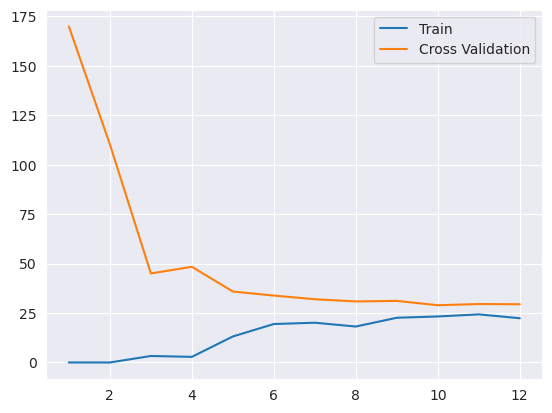

In [21]:
plt.plot(np.arange(1, len(X)+1), train_cost, label='Train')
plt.plot(np.arange(1, len(X)+1), cross_validation_cost, label='Cross Validation')
plt.legend(loc=1)
plt.show()

This reflects a high bias problem in the model. 因为训练集的数据太简单了

##  Polynomial regression
**多项式回归**

\begin{align*}
h_\theta(x) &= \theta_0 + \theta_1 \ast (\text{waterLevel}) + \theta_2 \ast (\text{waterLevel})^2 + \cdots + \theta_p \ast (\text{waterLevel})^p \\
            &= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_p x_p.
\end{align*}

标准化：
$$
X_{new} = \frac{x - \mu}{\sigma}
$$

In [22]:
def prepare_X_poly(*args, power):
    """

    :param args:
    :param power:
    :return:
    """

    def poly_features(X, power):
        data = {'f{}'.format(i): np.power(X, i) for i in range(1, power + 1)}
        df = pd.DataFrame(data)
        return df

    def normalize_feature(df):
        """
        Applies function along input axis(default 0) of DataFrame.
        df.apply(...) 对 DataFrame 的每一列（默认按列操作）应用指定的函数
        """
        return df.apply(lambda column:
                        (column - column.mean()) / column.std())

    def prepare(X):
        df = poly_features(X, power=power)

        ndarr = normalize_feature(df).values

        # add intercept term 加入截距
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(X) for X in args]

In [23]:
# 在上面X被插入了新的一行，需要重新读取X
X, y, Xval, yval, Xtest, ytest = load_data('ex5data1.mat')

X_poly, Xval_poly, Xtest_poly= prepare_X_poly(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## Learning curves

In [24]:
def plot_learning_curve(X, y, Xval, yval, lambda_=0):
    m = X.shape[0]
    training_cost, cv_cost = [], []

    for i in range(1, m+1):
        _x = X[:i, :]
        _y = y[:i]

        res = train_linear_reg(_x, _y, lambda_=lambda_)
        # 计算cost时不需要计算正则项，正则项只用于拟合
        tc = cost_reg(res, _x, _y, lambda_=0)
        cv = cost_reg(res, Xval, yval, lambda_=0)

        training_cost.append(tc)
        cv_cost.append(cv)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(np.arange(1, m+1), training_cost, label='Training cost')
    ax.plot(np.arange(1, m+1), cv_cost, label='Cv cost')
    ax.legend(loc='best', title=r'$\lambda={}$'.format(lambda_) )
    plt.show()

### CASE $\lambda = 0$

  NIT   NF   F                       GTG
    0    1  5.196208292205368E+00   3.17343613E+01
    1    3  9.860761315262648E-32   6.02217895E-31
tnc: |pg| = 7.76027e-16 -> local minimum
    1    3  9.860761315262648E-32   6.02217895E-31
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  3.686037992896324E+00   1.74005107E+01
    1    4  1.132863012598363E-16   6.29533317E-17
tnc: |pg| = 7.93431e-09 -> local minimum
    1    4  1.132863012598363E-16   6.29533317E-17
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.364046313185939E+02   5.94961274E+02
tnc: fscale = 0.0204987
    1    4  6.000560207608688E-01   2.63211495E-01
tnc: fscale = 0.97458
    2    8  9.747765096249052E-17   4.24606484E-16
tnc: |pg| = 2.11434e-08 -> local minimum
    2    8  9.747765096249052E-17   4.24606484E-16
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.141362053785440E+02   1.49259859E+0

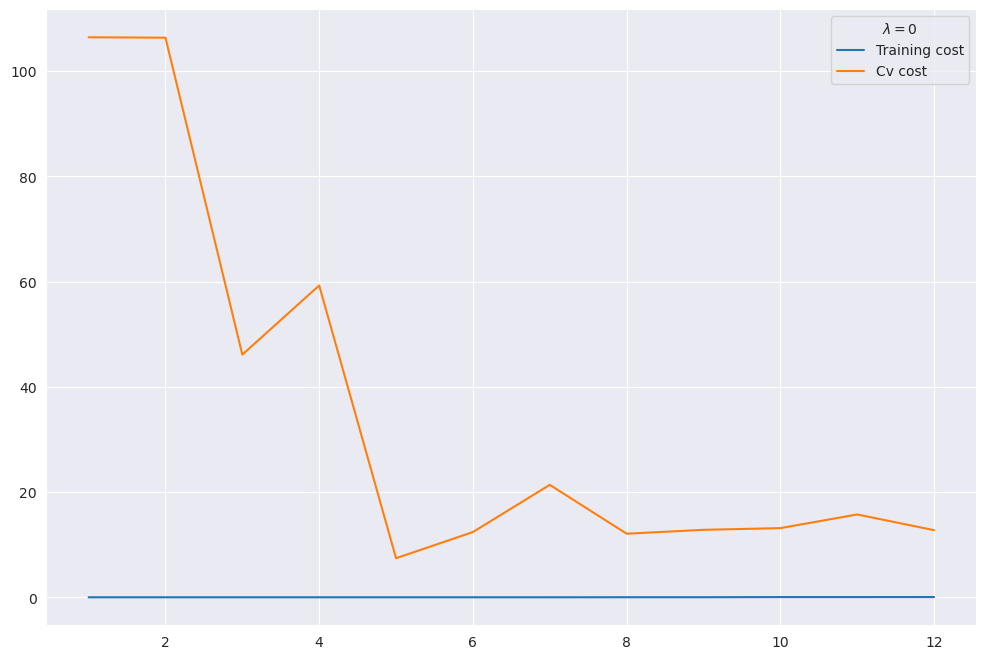

In [25]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lambda_=0)

可以看到训练的代价太低了，不真实. 这是 **过拟合**了

### CASE $\lambda =1$

  NIT   NF   F                       GTG
    0    1  9.196208292205368E+00   5.32057794E+01
    1    4  7.266489238927185E-03   3.84114407E-03
    2    7  7.439856461517416E-05   1.90689940E-04
tnc: fscale = 36.2081
    3   11  3.794912833110617E-19   2.11031222E-18
tnc: |pg| = 4.01206e-11 -> local minimum
    3   11  3.794912833110617E-19   2.11031222E-18
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  5.686037992896324E+00   2.47635192E+01
    1    4  8.395887485544498E-02   4.75161008E-03
    2    8  7.270184483654923E-02   7.52954986E-06
tnc: fscale = 182.216
    3   11  7.269436294899831E-02   1.86143094E-08
tnc: fscale = 3664.77
tnc: |fn-fn-1] = 7.42244e-09 -> convergence
    4   15  7.269435552656067E-02   1.44838572E-12
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.377379646519273E+02   5.66672779E+02
tnc: fscale = 0.0210041
    1    4  1.939519311683045E+01   1.40115003E+00
tnc: fscale = 0.42

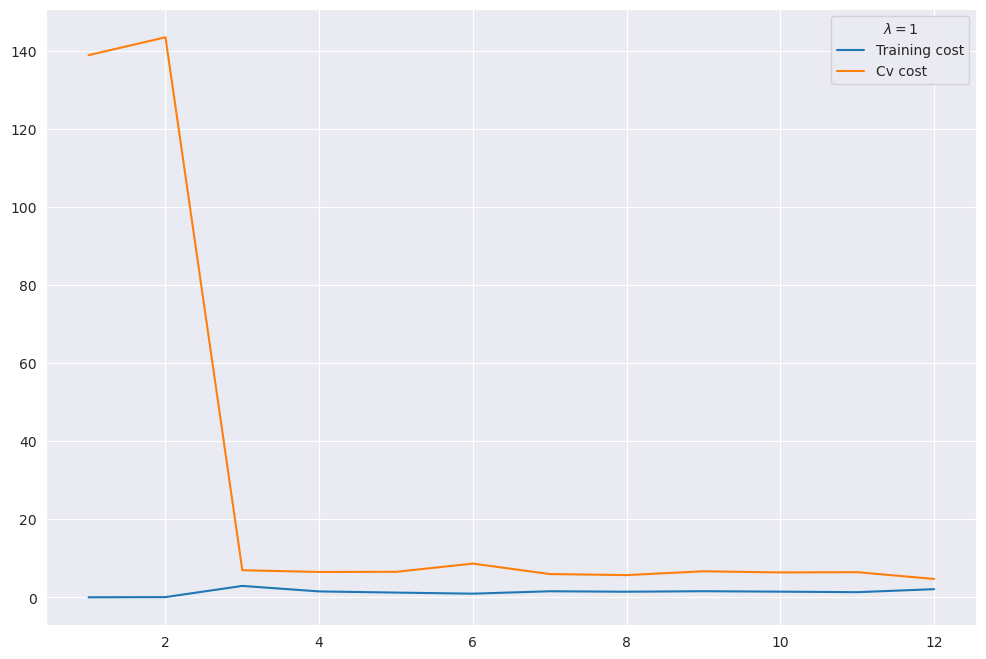

In [26]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lambda_=1)

训练代价增加了些，不再是0了。
也就是说我们减轻**过拟合**

### CASE $\lambda = 100$

  NIT   NF   F                       GTG
    0    1  4.051962082922054E+02   8.13788762E+04
tnc: fscale = 0.00175273
    1    4  5.832091070216597E-01   1.33251834E+00
tnc: fscale = 0.433145
    2    8  8.624199290958889E-18   1.72647670E-15
tnc: |pg| = 9.59283e-08 -> local minimum
    2    8  8.624199290958889E-18   1.72647670E-15
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.036860379928963E+02   2.05537014E+04
tnc: fscale = 0.00348759
    1    4  2.831008435195471E-01   3.56301816E-01
tnc: fscale = 0.837647
    2    8  1.147779356625165E-01   8.55452758E-09
tnc: fscale = 5405.95
tnc: |fn-fn-1] = 8.51075e-11 -> convergence
    3   11  1.147779355774090E-01   1.39831327E-18
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.697379646519273E+02   6.56611179E+03
tnc: fscale = 0.00617044
    1    4  1.433800288330096E+02   9.90613198E+02
    2    7  1.127877217888580E+02   3.29528693E-01
tnc: fscale = 0.

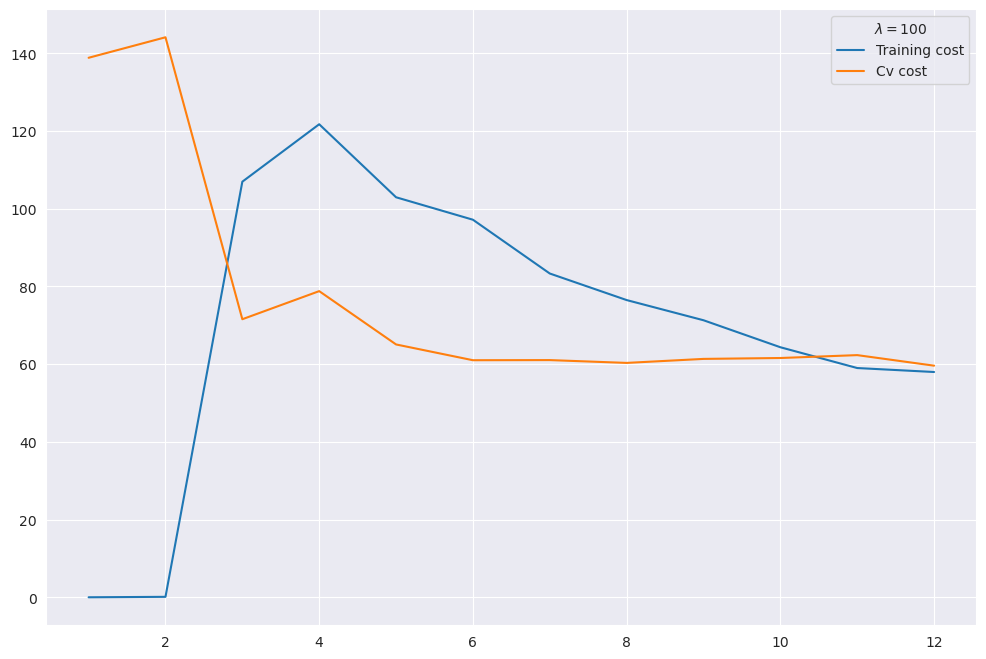

In [27]:
plot_learning_curve(X_poly, y, Xval_poly, yval, lambda_=100)

太多正则化了.
变成 **欠拟合**状态

## Selecting lambda

In [28]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost, test_cost = [], [], []

In [29]:
for l in l_candidate:
    res = train_linear_reg(X_poly, y, l)

    tc = cost_reg(res, X_poly, y, l)
    cv = cost_reg(res, Xval_poly, yval, l)
    test_c = cost_reg(res, Xtest_poly, ytest, l)
    training_cost.append(tc)
    cv_cost.append(cv)
    test_cost.append(test_c)

  NIT   NF   F                       GTG
    0    1  1.046321620777135E+02   3.09396153E+02
tnc: fscale = 0.0284258
    1    5  2.059424312700486E+00   5.93790974E-01
tnc: fscale = 0.648863
    2    9  9.749953511065641E-01   1.42221725E+00
    3   13  4.279080300450668E-01   2.36128615E-03
    4   18  2.422803190714194E-01   5.25418257E-05
tnc: fscale = 68.9791
    5   23  1.995561430813783E-01   1.40352324E-04
    6   28  1.928534928502346E-01   9.08279761E-03
    7   33  1.783201225094607E-01   1.31925513E-03
    8   36  1.776104625475143E-01   5.15578494E-05
    9   41  1.693889894618188E-01   7.93292976E-04
   10   46  1.582380103462040E-01   1.11724602E-03
tnc: stepmx = 1000
   11   51  1.051727301119241E-01   2.66787323E-03
   12   56  9.922226115863526E-02   2.84066032E-04
   13   61  8.279097969681808E-02   4.43541742E-04
   14   66  7.141740614158899E-02   1.36769947E-04
   15   69  7.133694841379229E-02   8.53548559E-05
   16   74  6.382317757842916E-02   1.71459886E-04
   1

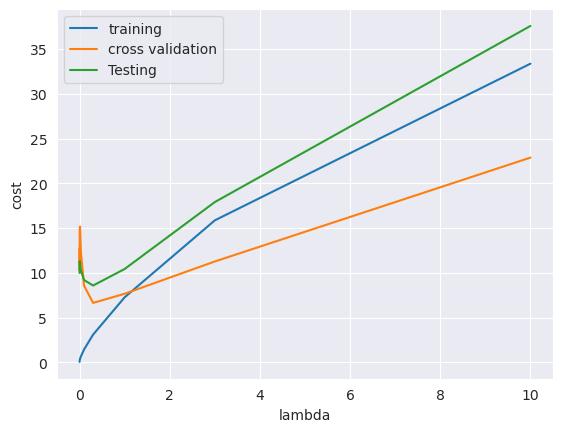

In [31]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.plot(l_candidate, test_cost, label='Testing')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [62]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]

1

In [33]:
# best test I got from all those candidates
l_candidate[np.argmin(test_cost)]

0.3

调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小